In [1]:
# ============================== [CELL 1] ==============================
# 1) Import necessary libraries, disable warnings, set up environment

import os
import re
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

# Disable huggingface/tokenizers parallel warnings
os.environ["TOKENIZERS_PARALLELISM"] = "true"

# Matplotlib for plotting
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.size"] = 15

from matplotlib.lines import Line2D
from typing import Counter
from wordcloud import WordCloud
from datetime import datetime
import pickle

# NLTK
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

# Stop-words
from stop_words import get_stop_words

# Language detection
from language_detector import detect_language

# SymSpell for typo correction
import pkg_resources
from symspellpy import SymSpell, Verbosity

# TF-IDF
from sklearn.feature_extraction.text import TfidfVectorizer

# Gensim (LDA)
import gensim
from gensim import corpora
from gensim.models.coherencemodel import CoherenceModel

# K-Means
from sklearn.cluster import KMeans

# Keras (for Autoencoder)
import keras
from keras.layers import Input, Dense
from keras.models import Model
from sklearn.model_selection import train_test_split

# UMAP
import umap

# Metrics
from sklearn.metrics import (
    silhouette_score,
    calinski_harabasz_score,
    davies_bouldin_score,
    adjusted_rand_score,
    homogeneity_score,
    completeness_score,
    v_measure_score
)

print("All necessary libraries have been imported.")


[nltk_data] Downloading package punkt to
[nltk_data]     /Users/talgatazykanov/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/talgatazykanov/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


All necessary libraries have been imported.


In [2]:
# ============================== [CELL 2] ==============================
# 2) Preprocessing functions and SymSpell initialization

# Initialize SymSpell
sym_spell = SymSpell(max_dictionary_edit_distance=3, prefix_length=7)
dictionary_path = pkg_resources.resource_filename("symspellpy", "frequency_dictionary_en_82_765.txt")
if not sym_spell.word_count:
    sym_spell.load_dictionary(dictionary_path, term_index=0, count_index=1)

def f_base(s: str) -> str:
    """
    Basic text normalization.
    """
    # 1. 'aA' -> 'a. A'
    s = re.sub(r'([a-z])([A-Z])', r'\1\. \2', s)
    # 2. lowercase
    s = s.lower()
    # 3. remove HTML entities
    s = re.sub(r'&gt|&lt', ' ', s)
    # 4. repeating letters (>2)
    s = re.sub(r'([a-z])\1{2,}', r'\1', s)
    # 5. repeating non-letters
    s = re.sub(r'([\W+])\1{1,}', r'\1', s)
    # 6. '*' -> '. '
    s = re.sub(r'\*|\W\*|\*\W', '. ', s)
    # 7. content inside parentheses
    s = re.sub(r'\(.*?\)', '. ', s)
    # 8. '???...' -> '.'
    s = re.sub(r'\W+?\.', '.', s)
    # 9. ".A" -> ". A"
    s = re.sub(r'(\.|\?|!)(\w)', r'\1 \2', s)
    # 10. remove " ing "
    s = re.sub(r' ing ', ' ', s)
    # 11. remove "product received for free"
    s = re.sub(r'product received for free[.| ]', ' ', s)
    # 12. repeated phrases
    s = re.sub(r'(.{2,}?)\1{1,}', r'\1', s)

    return s.strip()

def f_lan(s: str) -> bool:
    """
    Verify that the text language is English/French.
    """
    return detect_language(s) in {'English', 'French'}

def f_punct(w_list):
    """
    Remove punctuation and digits.
    """
    return [word for word in w_list if word.isalpha()]

def f_noun(w_list):
    """
    Keep only nouns (NN).
    """
    return [word for (word, pos) in nltk.pos_tag(w_list) if pos[:2] == 'NN']

def f_typo(w_list):
    """
    Fix typos using SymSpell.
    """
    fixed_words = []
    for word in w_list:
        suggestions = sym_spell.lookup(word, Verbosity.CLOSEST, max_edit_distance=3)
        if suggestions:
            fixed_words.append(suggestions[0].term)
    return fixed_words

p_stemmer = PorterStemmer()

def f_stem(w_list):
    """
    Stemming words.
    """
    return [p_stemmer.stem(word) for word in w_list]

en_stop = get_stop_words('en')
en_stop += ['game', 'play', 'player', 'time']

def f_stopw(w_list):
    """
    Remove stopwords.
    """
    return [word for word in w_list if word not in en_stop]

def preprocess_sent(rw: str) -> str:
    """
    Document-level preprocessing.
    """
    s = f_base(rw)
    if not f_lan(s):
        return None
    return s

def preprocess_word(s: str):
    """
    Token-level preprocessing pipeline:
      1) tokenize
      2) remove punctuation/digits
      3) keep nouns
      4) fix typos
      5) stem
      6) remove stopwords
    """
    if not s:
        return None
    w_list = word_tokenize(s)
    w_list = f_punct(w_list)
    w_list = f_noun(w_list)
    w_list = f_typo(w_list)
    w_list = f_stem(w_list)
    w_list = f_stopw(w_list)
    return w_list

print("Preprocessing functions are ready.")


Preprocessing functions are ready.


In [3]:
# ============================== [CELL 3] ==============================
# 3) Autoencoder class (for LDA+BERT scenario)

class Autoencoder:
    """
    A simple one-layer Autoencoder (latent_dim is the hidden layer size).
    """
    def __init__(self, latent_dim=32, activation='relu', epochs=200, batch_size=128):
        self.latent_dim = latent_dim
        self.activation = activation
        self.epochs = epochs
        self.batch_size = batch_size
        self.autoencoder = None
        self.encoder = None
        self.decoder = None
        self.his = None

    def _compile(self, input_dim):
        """
        Build and compile the autoencoder model.
        """
        input_vec = Input(shape=(input_dim,))
        encoded = Dense(self.latent_dim, activation=self.activation)(input_vec)
        decoded = Dense(input_dim, activation=self.activation)(encoded)

        self.autoencoder = Model(input_vec, decoded)
        self.encoder = Model(input_vec, encoded)

        # Build decoder
        encoded_input = Input(shape=(self.latent_dim,))
        decoder_layer = self.autoencoder.layers[-1]
        self.decoder = Model(encoded_input, decoder_layer(encoded_input))

        self.autoencoder.compile(optimizer='adam', loss=keras.losses.mean_squared_error)

    def fit(self, X):
        """
        Train the autoencoder.
        """
        if not self.autoencoder:
            self._compile(X.shape[1])

        X_train, X_test = train_test_split(X, test_size=0.2, random_state=42)
        self.his = self.autoencoder.fit(
            X_train, X_train,
            epochs=self.epochs,
            batch_size=self.batch_size,
            shuffle=True,
            validation_data=(X_test, X_test),
            verbose=0
        )

        # Plot training loss
        plt.figure(figsize=(6,4), dpi=350)
        plt.plot(self.his.history['loss'], label='Train Loss')
        plt.plot(self.his.history['val_loss'], label='Validation Loss')
        plt.title('Autoencoder Loss by Epoch')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()

print("Autoencoder class has been defined.")


Autoencoder class has been defined.


In [4]:
# ============================== [CELL 4] ==============================
# 4) Auxiliary functions: get_vec_lda, evaluate_clustering, etc.

def get_vec_lda(lda_model, corpus, k):
    """
    Get LDA vectors of shape (n_docs x k).
    """
    n_doc = len(corpus)
    vec_lda = np.zeros((n_doc, k))
    for i in range(n_doc):
        topics_probs = lda_model.get_document_topics(corpus[i])
        for topic, prob in topics_probs:
            vec_lda[i, topic] = prob
    return vec_lda

def evaluate_clustering(X, labels, ground_truth=None):
    """
    Compute clustering metrics:
      - silhouette
      - calinski_harabasz
      - davies_bouldin
      - adjusted_rand, homogeneity, completeness, v_measure (if ground_truth)
    """
    if hasattr(X, 'toarray'):
        X = X.toarray()

    metrics_dict = {}
    # Internal clustering metrics
    metrics_dict['silhouette'] = silhouette_score(X, labels)
    metrics_dict['calinski_harabasz'] = calinski_harabasz_score(X, labels)
    metrics_dict['davies_bouldin'] = davies_bouldin_score(X, labels)

    # External metrics (if we have ground truth)
    if ground_truth is not None:
        metrics_dict['adjusted_rand'] = adjusted_rand_score(ground_truth, labels)
        metrics_dict['homogeneity'] = homogeneity_score(ground_truth, labels)
        metrics_dict['completeness'] = completeness_score(ground_truth, labels)
        metrics_dict['v_measure'] = v_measure_score(ground_truth, labels)
    return metrics_dict

print("Auxiliary functions (get_vec_lda, evaluate_clustering) are ready.")


Auxiliary functions (get_vec_lda, evaluate_clustering) are ready.


In [5]:
# ============================== [CELL 5] ==============================
# 5) Topic_Model class: supports TFIDF, BERT, LDA, LDA_BERT

from sentence_transformers import SentenceTransformer

class Topic_Model:
    def __init__(self, k=5, method='TFIDF'):
        """
        k: number of clusters/topics
        method: one of {TFIDF, BERT, LDA, LDA_BERT}
        """
        if method not in {'TFIDF', 'BERT', 'LDA', 'LDA_BERT'}:
            raise ValueError("method must be TFIDF, BERT, LDA, or LDA_BERT")

        self.k = k
        self.dictionary = None
        self.corpus = None
        self.cluster_model = None
        self.ldamodel = None
        self.vec = {}         # для хранения векторов после fit
        self.gamma = 15       # масштаб для LDA части в LDA_BERT
        self.method = method
        self.AE = None        # Autoencoder для LDA_BERT
        self.id = f"{method}_{datetime.now().strftime('%Y_%m_%d_%H_%M_%S')}"

        # Здесь храним сопоставление кластер -> метка
        self.topic_labels = {
            0: 'tech',
            1: 'business',
            2: 'sport',
            3: 'entertainment',
            4: 'politics'
        }

        # Сами "векторизаторы":
        self.tfidf_vectorizer = None  # для TF-IDF
        self.bert_encoder = None      # для BERT

    def vectorize(self, sentences, token_lists):
        """
        Генерация векторных представлений в зависимости от self.method.
        """
        import numpy as np
        
        # Для LDA - нужно self.dictionary, self.ldamodel
        # Для BERT - self.bert_encoder
        # Для TF-IDF - self.tfidf_vectorizer

        if self.method == 'TFIDF':
            # Используем self.tfidf_vectorizer (уже обученный!)
            if not self.tfidf_vectorizer:
                raise ValueError("TF-IDF vectorizer is not set. Did you call fit() already?")
            return self.tfidf_vectorizer.transform(sentences)

        elif self.method == 'LDA':
            # Обычно при LDA "predict" мы берём bow -> ldamodel.get_document_topics(...)
            # Но если хотим вернуть "vector", можем делать get_vec_lda
            if not self.ldamodel or not self.dictionary:
                raise ValueError("LDA model or dictionary not set. Did you call fit() for LDA?")
            # Здесь token_lists нужны для bow
            new_corpus = [self.dictionary.doc2bow(toks) for toks in token_lists]
            vec_lda = get_vec_lda(self.ldamodel, new_corpus, self.k)
            return vec_lda

        elif self.method == 'BERT':
            # используем self.bert_encoder
            if not self.bert_encoder:
                raise ValueError("BERT encoder is not set. Did you call fit() already?")
            vec_bert = self.bert_encoder.encode(sentences, show_progress_bar=False)
            return np.array(vec_bert)

        elif self.method == 'LDA_BERT':
            # Нужно повторить логику: LDA + BERT => combine => AE
            if not self.ldamodel or not self.dictionary:
                raise ValueError("LDA model/dictionary not set. Did you call fit() for LDA_BERT?")
            new_corpus = [self.dictionary.doc2bow(toks) for toks in token_lists]
            vec_lda_part = get_vec_lda(self.ldamodel, new_corpus, self.k)

            if not self.bert_encoder:
                raise ValueError("BERT encoder is not set for LDA_BERT.")
            import numpy as np
            vec_bert_part = self.bert_encoder.encode(sentences, show_progress_bar=False)
            vec_bert_part = np.array(vec_bert_part)

            vec_ldabert_full = np.c_[vec_lda_part * self.gamma, vec_bert_part]
            
            if not self.AE:
                raise ValueError("Autoencoder not trained for LDA_BERT. Did you call fit() first?")
            vec_ldabert_latent = self.AE.encoder.predict(vec_ldabert_full)
            return vec_ldabert_latent

        else:
            raise ValueError(f"Unknown method: {self.method}")

    def fit(self, sentences, token_lists):
        """
        Обучение модели:
        - TF-IDF -> fit TF-IDF + KMeans
        - BERT -> encode + KMeans
        - LDA -> build Gensim LDA
        - LDA_BERT -> LDA + BERT + combine + AE + KMeans
        """
        from sklearn.cluster import KMeans
        
        if self.method == 'TFIDF':
            # 1) Создаем и обучаем TfidfVectorizer
            self.tfidf_vectorizer = TfidfVectorizer()
            X_tfidf = self.tfidf_vectorizer.fit_transform(sentences)

            # 2) Обучаем KMeans
            self.cluster_model = KMeans(n_clusters=self.k, random_state=42)
            self.cluster_model.fit(X_tfidf)
            self.vec['TFIDF'] = X_tfidf  # (опционально) сохраняем матрицу признаков

            print("[TF-IDF] fit done.")

            # Дополнительно: сохраняем tfidf_vectorizer в отдельный файл
            import pickle
            with open("tfidf_vectorizer.pkl", "wb") as f:
                pickle.dump(self.tfidf_vectorizer, f)
            
            # При желании, можно сохранить и сам KMeans-кластеризатор отдельно
            with open("tfidf_cluster_model.pkl", "wb") as f:
                pickle.dump(self.cluster_model, f)

        
        elif self.method == 'BERT':
            # 1) Инициализируем BERT
            self.bert_encoder = SentenceTransformer('bert-base-nli-max-tokens')
            X_bert = self.bert_encoder.encode(sentences, show_progress_bar=True)
            X_bert = np.array(X_bert)
            # 2) KMeans
            self.cluster_model = KMeans(n_clusters=self.k, random_state=42)
            self.cluster_model.fit(X_bert)
            self.vec['BERT'] = X_bert
            print("[BERT] fit done.")

        elif self.method == 'LDA':
            # Gensim LDA
            self.dictionary = corpora.Dictionary(token_lists)
            self.corpus = [self.dictionary.doc2bow(toks) for toks in token_lists]
            self.ldamodel = gensim.models.ldamodel.LdaModel(
                self.corpus,
                num_topics=self.k,
                id2word=self.dictionary,
                passes=20,
                random_state=42
            )
            print("[LDA] fit done (no KMeans).")

        elif self.method == 'LDA_BERT':
            # 1) LDA part
            self.dictionary = corpora.Dictionary(token_lists)
            self.corpus = [self.dictionary.doc2bow(toks) for toks in token_lists]
            self.ldamodel = gensim.models.ldamodel.LdaModel(
                self.corpus,
                num_topics=self.k,
                id2word=self.dictionary,
                passes=20,
                random_state=42
            )
            # get lda vector
            vec_lda = get_vec_lda(self.ldamodel, self.corpus, self.k)

            # 2) BERT part
            self.bert_encoder = SentenceTransformer('bert-base-nli-max-tokens')
            X_bert = self.bert_encoder.encode(sentences, show_progress_bar=True)
            X_bert = np.array(X_bert)

            # combine
            vec_ldabert_full = np.c_[vec_lda * self.gamma, X_bert]

            # AE
            self.AE = Autoencoder()
            self.AE.fit(vec_ldabert_full)
            vec_ldabert_latent = self.AE.encoder.predict(vec_ldabert_full)

            # KMeans
            self.cluster_model = KMeans(n_clusters=self.k, random_state=42)
            self.cluster_model.fit(vec_ldabert_latent)
            self.vec['LDA_BERT'] = vec_ldabert_latent
            print("[LDA_BERT] fit done.")

    def predict(self, new_sentences, new_token_lists):
        """
        Предсказание для новых документов. 
        Использует уже обученный векторизатор (TF-IDF/BERT/..., etc).
        Если LDA, возвращает индекс лучшей темы.
        Если TF-IDF/BERT/LDA_BERT, возвращает результат KMeans predict.
        """
        if self.method == 'LDA':
            # pure LDA => bow -> best topic
            new_corpus = [self.dictionary.doc2bow(toks) for toks in new_token_lists]
            preds = []
            for bow in new_corpus:
                topics_probs = self.ldamodel.get_document_topics(bow)
                if topics_probs:
                    best_topic_id = max(topics_probs, key=lambda x: x[1])[0]
                else:
                    best_topic_id = -1
                preds.append(best_topic_id)
            return preds
        else:
            # TF-IDF, BERT, LDA_BERT
            X_new = self.vectorize(new_sentences, new_token_lists)
            cluster_ids = self.cluster_model.predict(X_new)
            return cluster_ids


print("Topic_Model with vectorizers is ready.")


Topic_Model with vectorizers is ready.


In [6]:
import pandas as pd
from joblib import Parallel, delayed  # For parallel processing
import tensorflow as tf  # To leverage GPU if needed

# Example: Preprocessing functions
def preprocess_sent(text):
    """Example sentence preprocessing function."""
    return text.lower()  # Add your actual preprocessing logic here

def preprocess_word(sentence):
    """Example tokenization function."""
    return sentence.split()  # Replace with your actual tokenization logic

# Load data and preprocess using parallel computation
print("Loading dataset...")

data_path = "bbc-text.csv"  # Change if needed
df = pd.read_csv(data_path)
print(f"Dataset loaded. Number of rows: {len(df)}")

# If there's a 'category' column, we use it
categories = df['category'].values if 'category' in df.columns else None

# Define parallel preprocessing function
def preprocess_text(index, text):
    """Preprocess a single text: cleaning and tokenization."""
    s_pre = preprocess_sent(text)
    w_pre = preprocess_word(s_pre)
    return (index, s_pre, w_pre)

print("Preprocessing data in parallel...")

# Use parallel processing for text preprocessing
results = Parallel(n_jobs=-1, backend="loky")(delayed(preprocess_text)(i, text) for i, text in enumerate(df['text']))

# Extract processed sentences and token lists
sentences = [result[1] for result in results if result[2]]  # Filter out empty token lists
token_lists = [result[2] for result in results if result[2]]

print(f"Total documents after preprocessing: {len(sentences)}")
print("Data is now ready for model training.")

# OPTIONAL: If using GPU, you can test TensorFlow with tf.data for better GPU utilization
# Note: Use TensorFlow for large datasets or heavy operations
dataset = tf.data.Dataset.from_tensor_slices(sentences)
print("TensorFlow dataset created. Ready for GPU processing if needed.")


Loading dataset...
Dataset loaded. Number of rows: 2225
Preprocessing data in parallel...
Total documents after preprocessing: 2225
Data is now ready for model training.
TensorFlow dataset created. Ready for GPU processing if needed.


2025-01-14 10:30:28.894014: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2025-01-14 10:30:28.894053: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2025-01-14 10:30:28.894056: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2025-01-14 10:30:28.894090: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-01-14 10:30:28.894104: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


=== Start of snippet code for training and visualization ===
Notebook snippet for training TF-IDF, BERT, and LDA_BERT models.
=== METHOD 1: TF-IDF + KMeans ===
TF-IDF vectorizer saved as tfidf_vectorizer.pkl.

--- TF-IDF + KMeans METRICS ---
silhouette: 0.0029
calinski_harabasz: 14.4955
davies_bouldin: 8.0584
adjusted_rand: 0.4277
homogeneity: 0.5581
completeness: 0.6408
v_measure: 0.5966


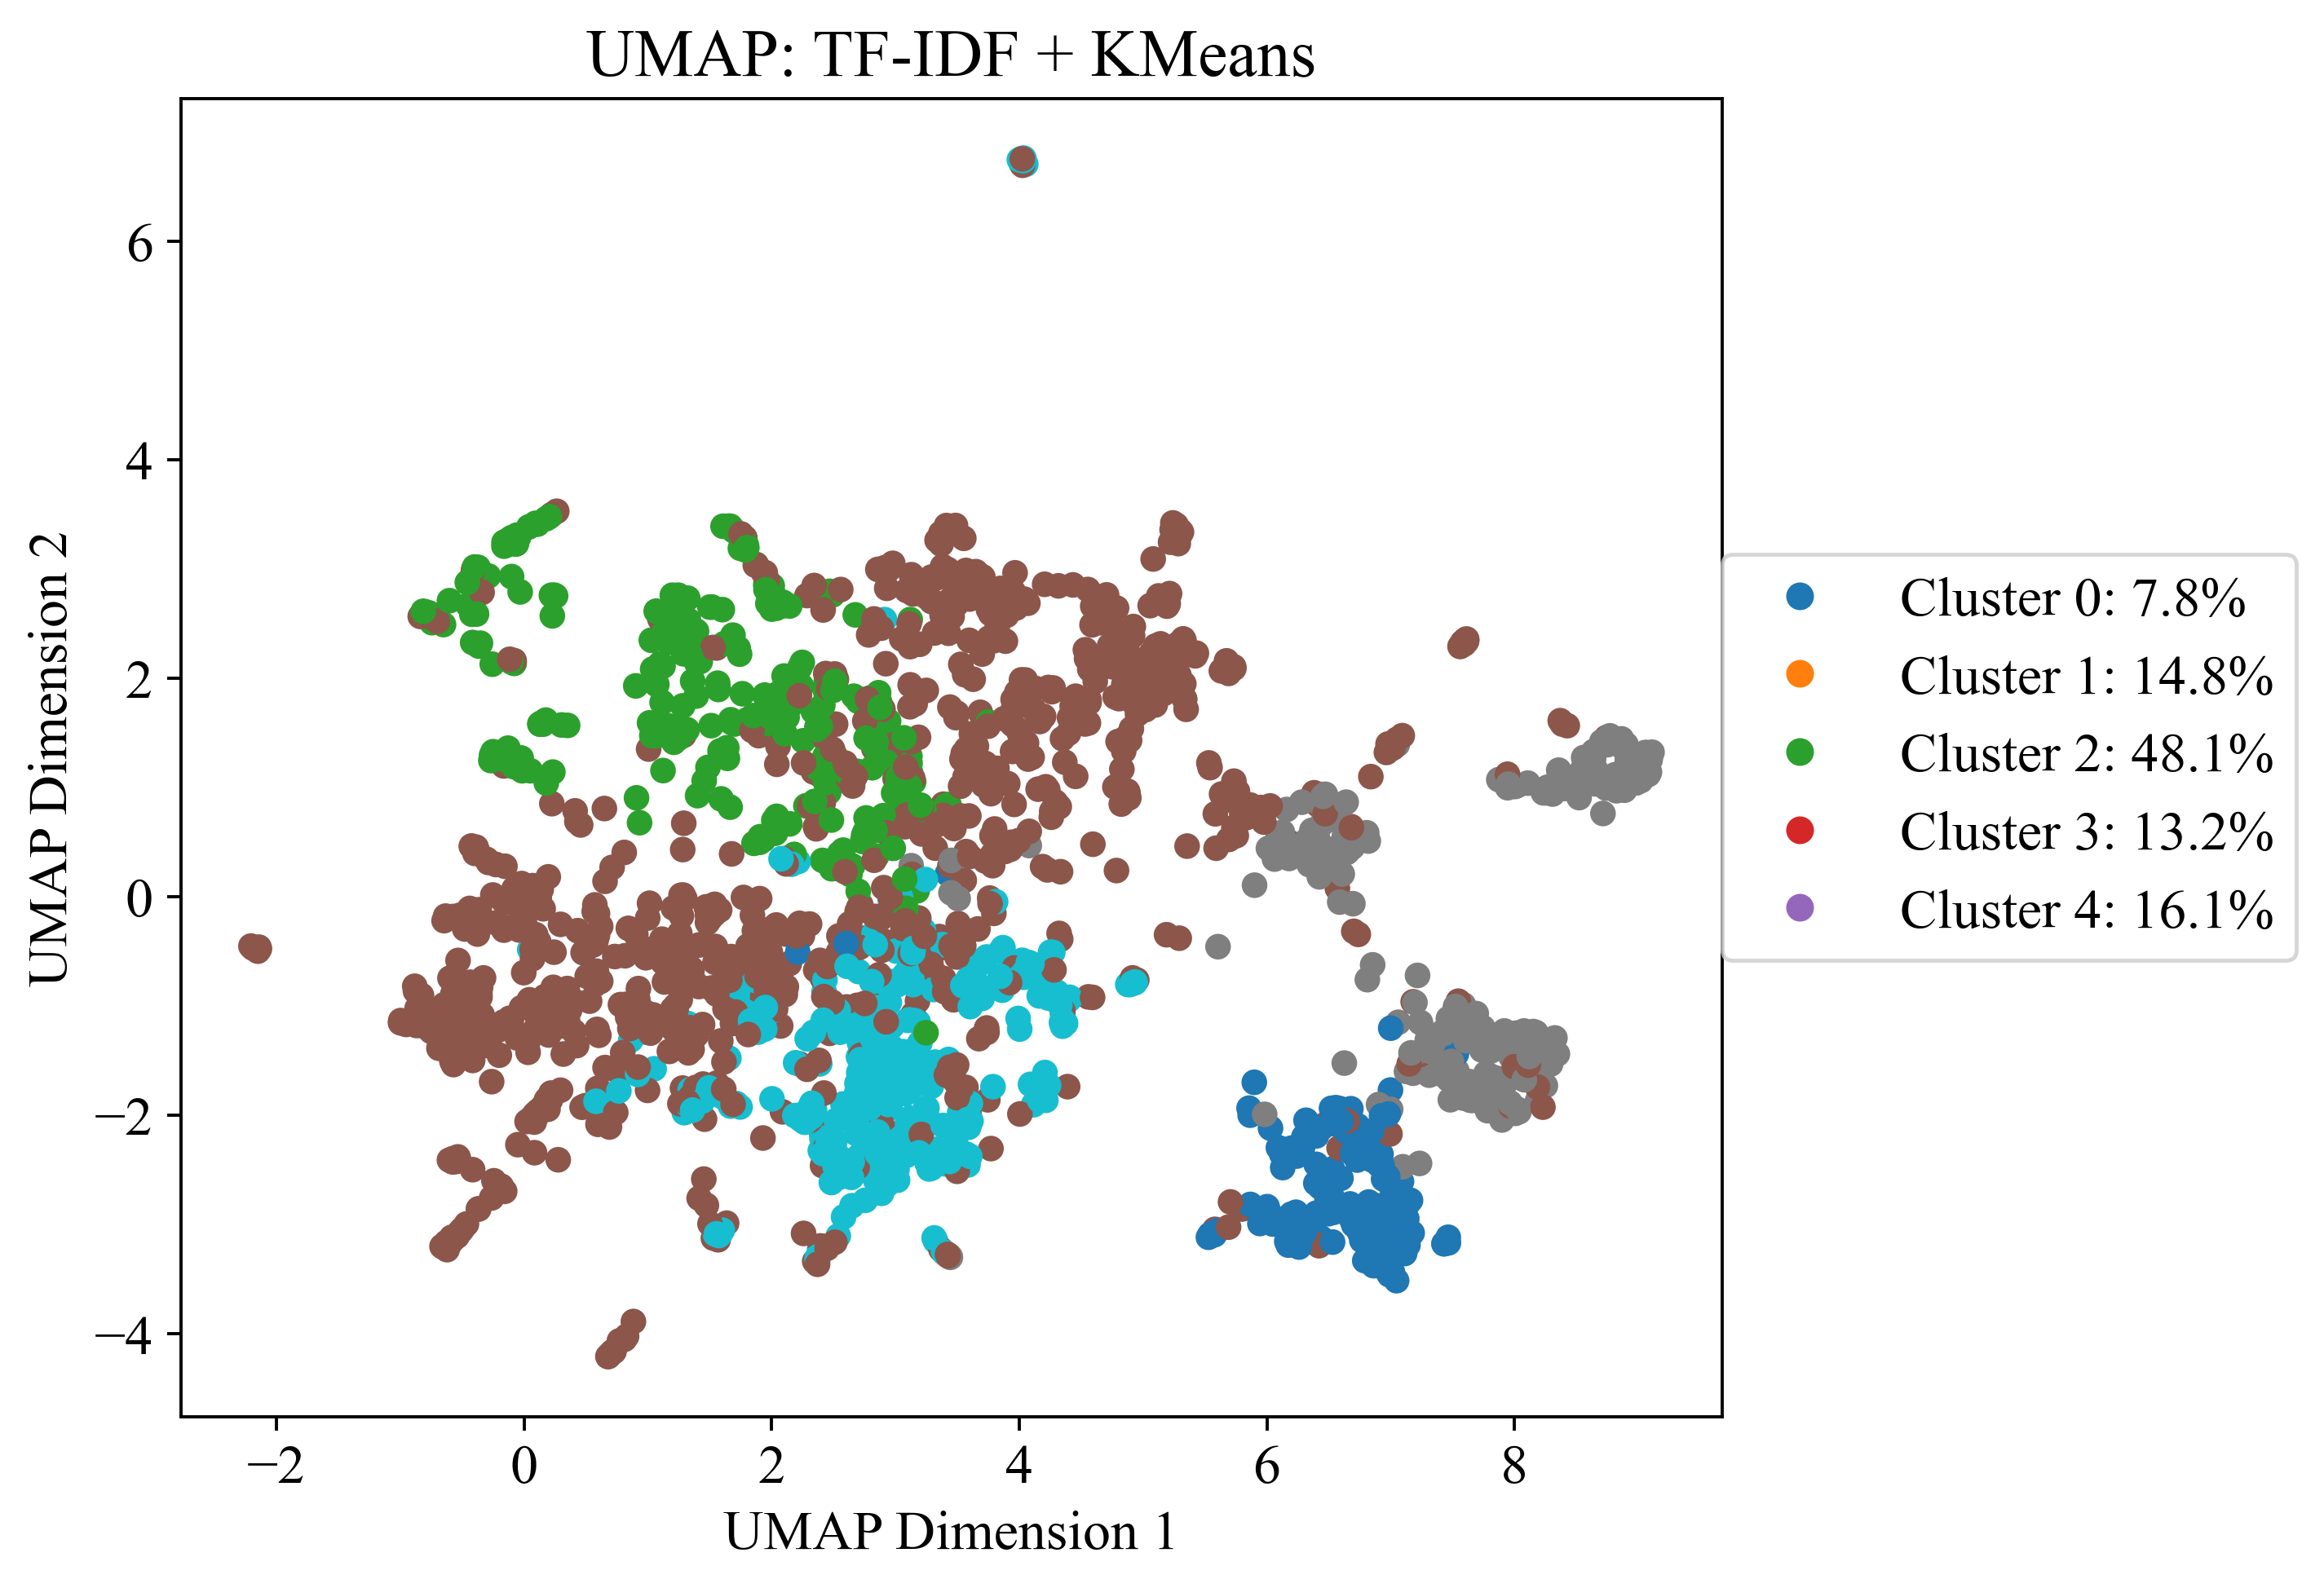

TF-IDF model saved as tfidf_model.pkl.

=== METHOD 2: BERT + KMeans ===


Batches:   0%|          | 0/70 [00:00<?, ?it/s]

[BERT] fit done.

--- BERT + KMeans METRICS ---
silhouette: 0.0528
calinski_harabasz: 102.1483
davies_bouldin: 3.5202
adjusted_rand: 0.3837
homogeneity: 0.4128
completeness: 0.4124
v_measure: 0.4126


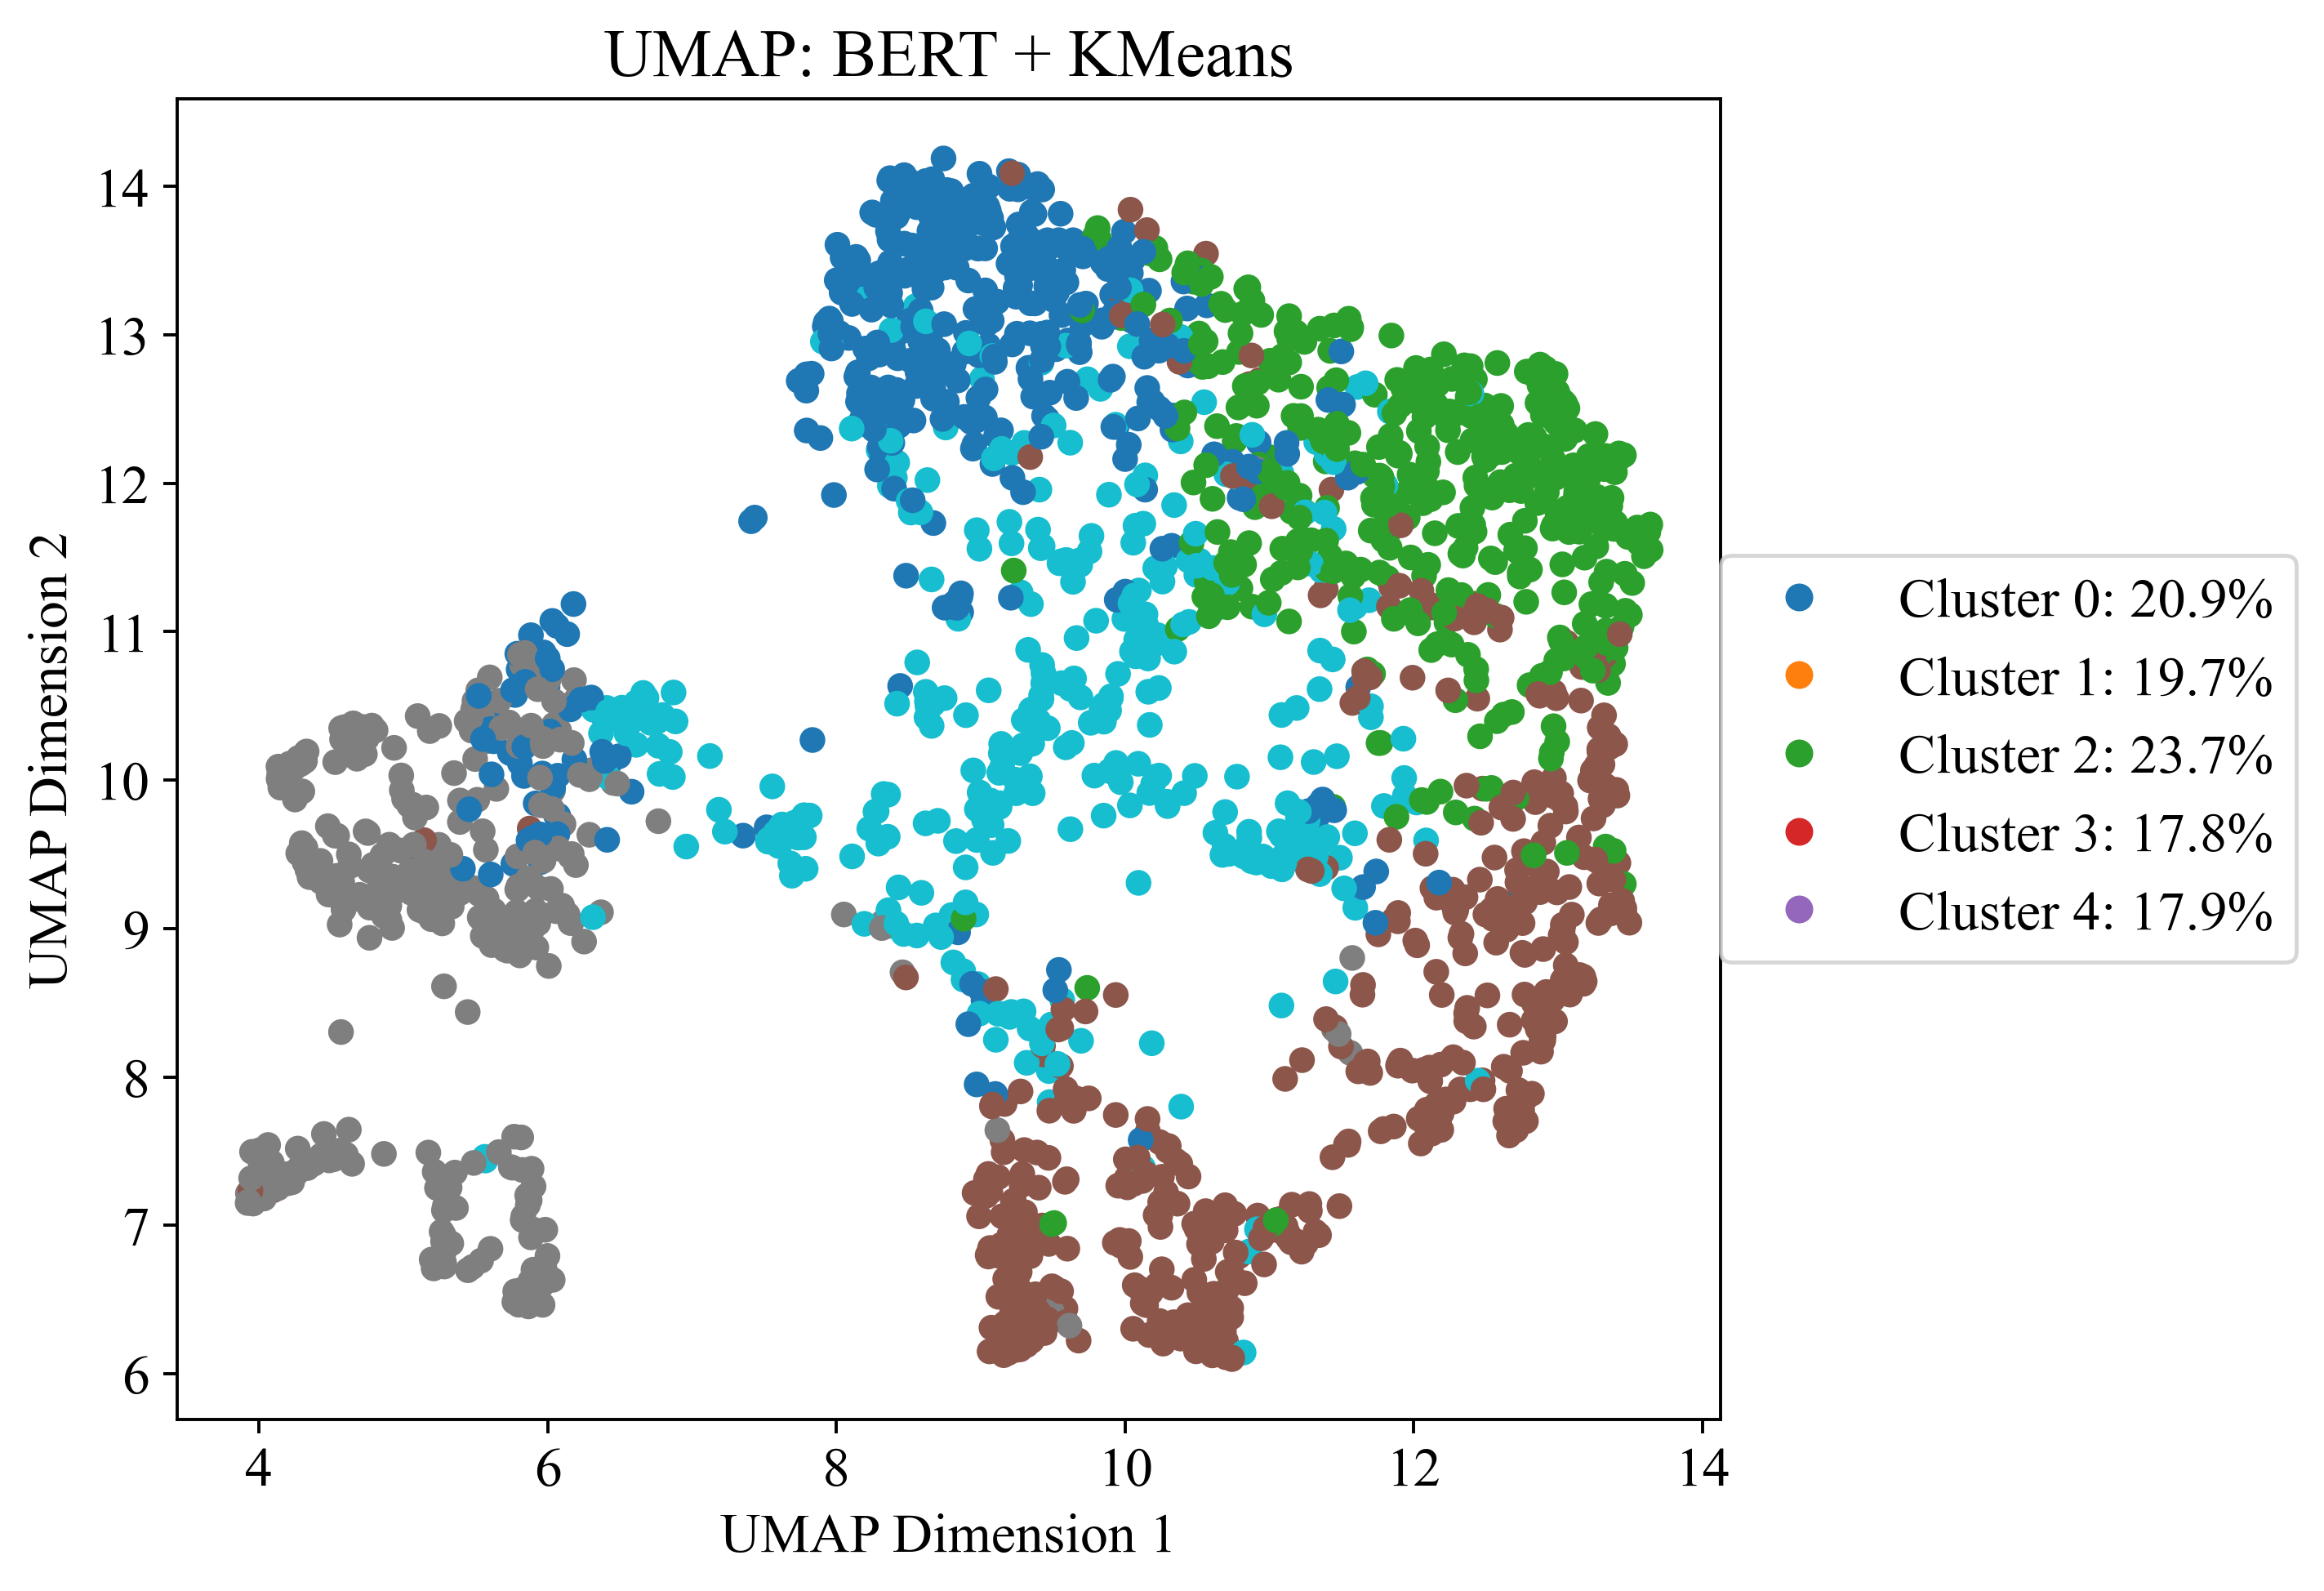

BERT model saved as bert_model.pkl.

=== METHOD 3: LDA_BERT + KMeans ===


Batches:   0%|          | 0/70 [00:00<?, ?it/s]

2025-01-14 10:31:43.982811: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


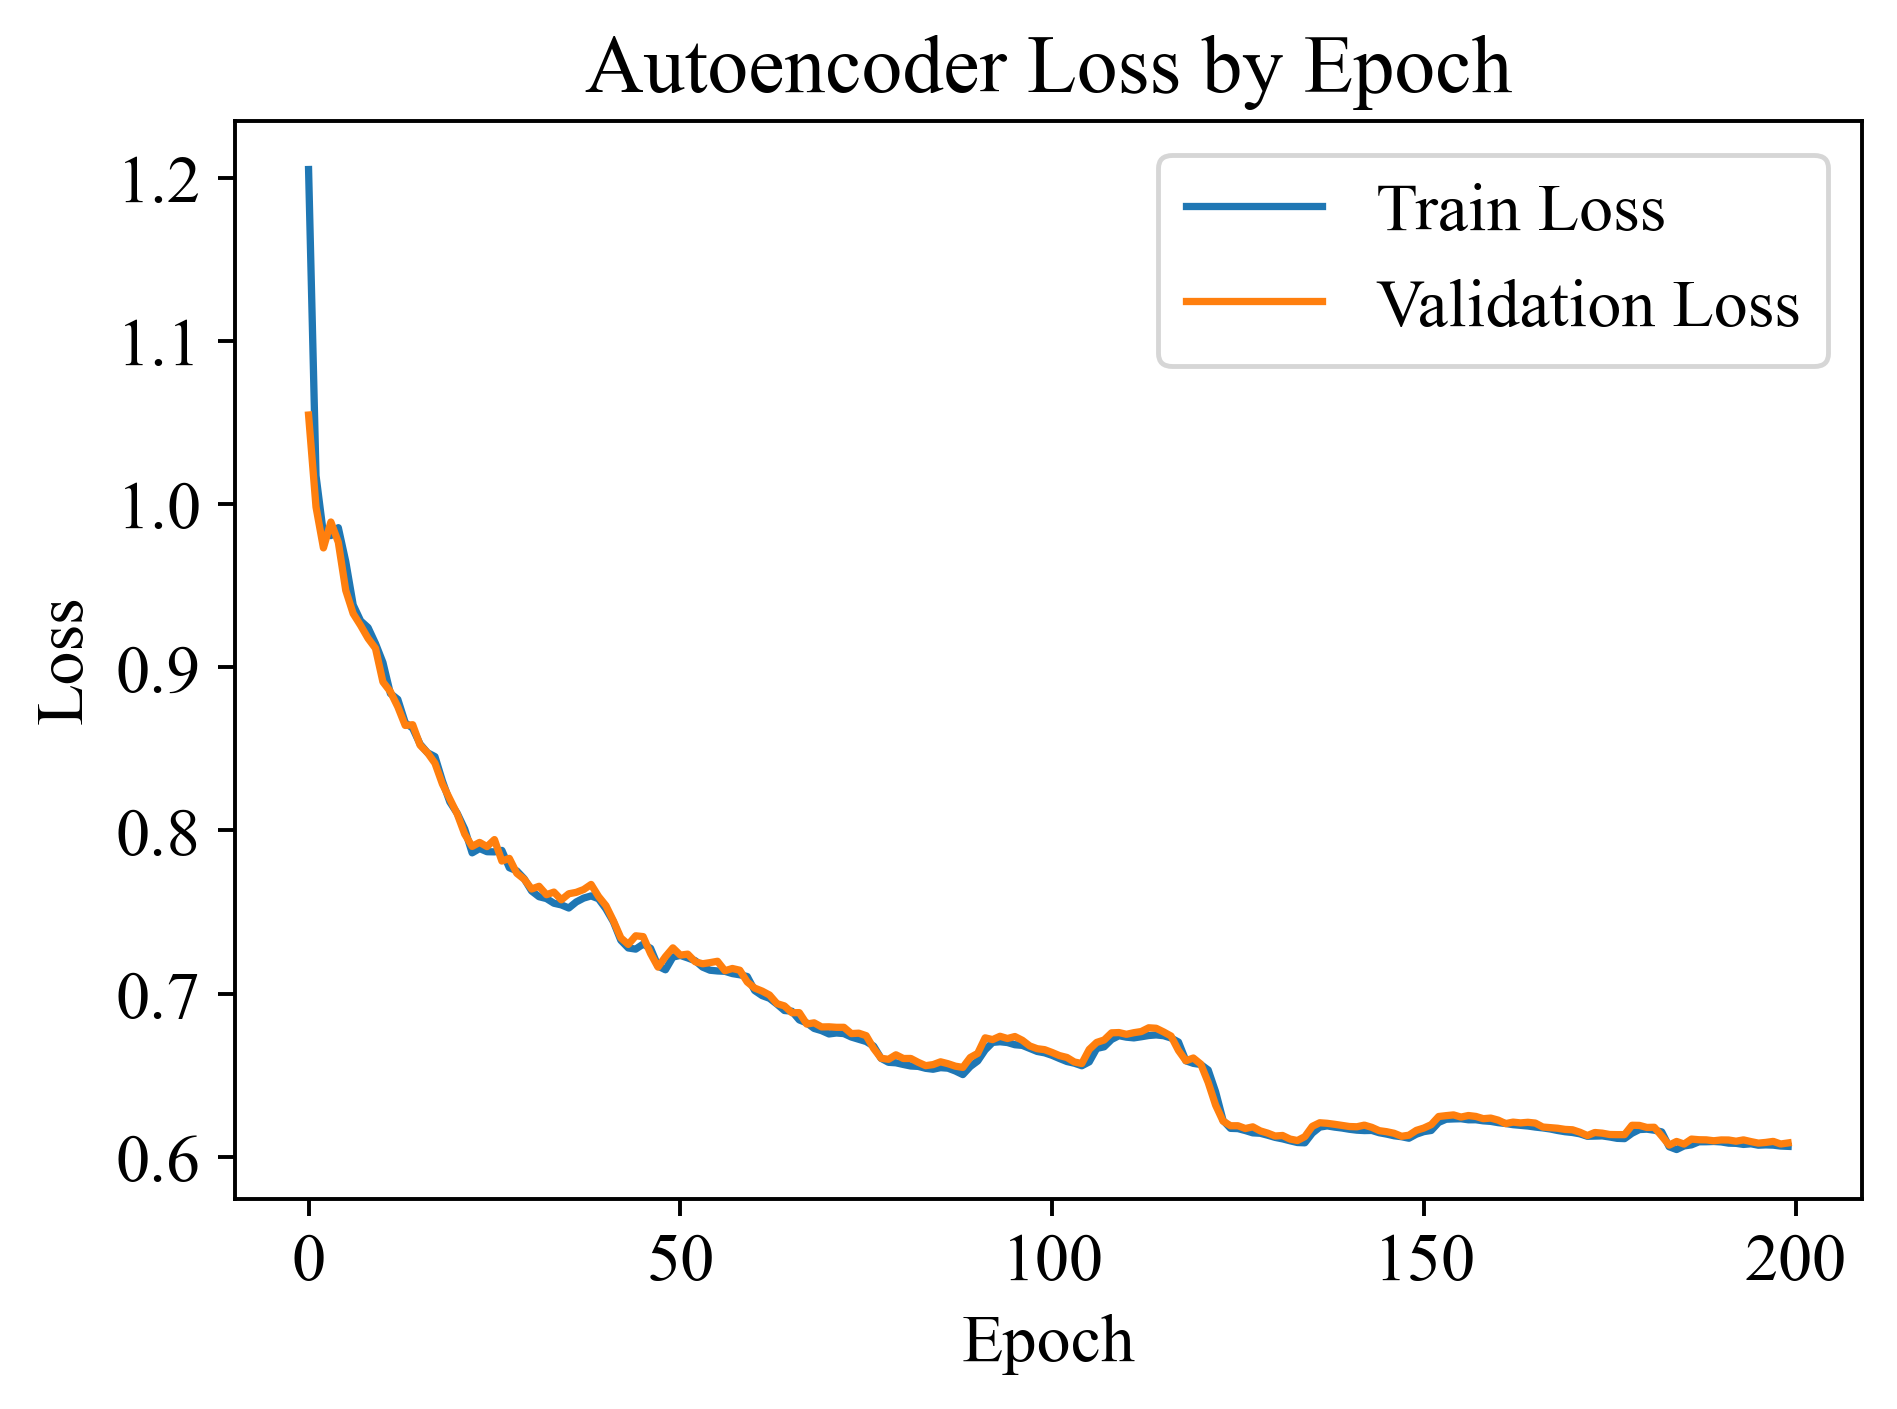

70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
[LDA_BERT] fit done.

--- LDA_BERT + KMeans METRICS ---
silhouette: 0.2258
calinski_harabasz: 1488.9133
davies_bouldin: 1.5869
adjusted_rand: 0.4185
homogeneity: 0.4659
completeness: 0.4779
v_measure: 0.4718
Coherence (LDA part, c_v): 0.3413


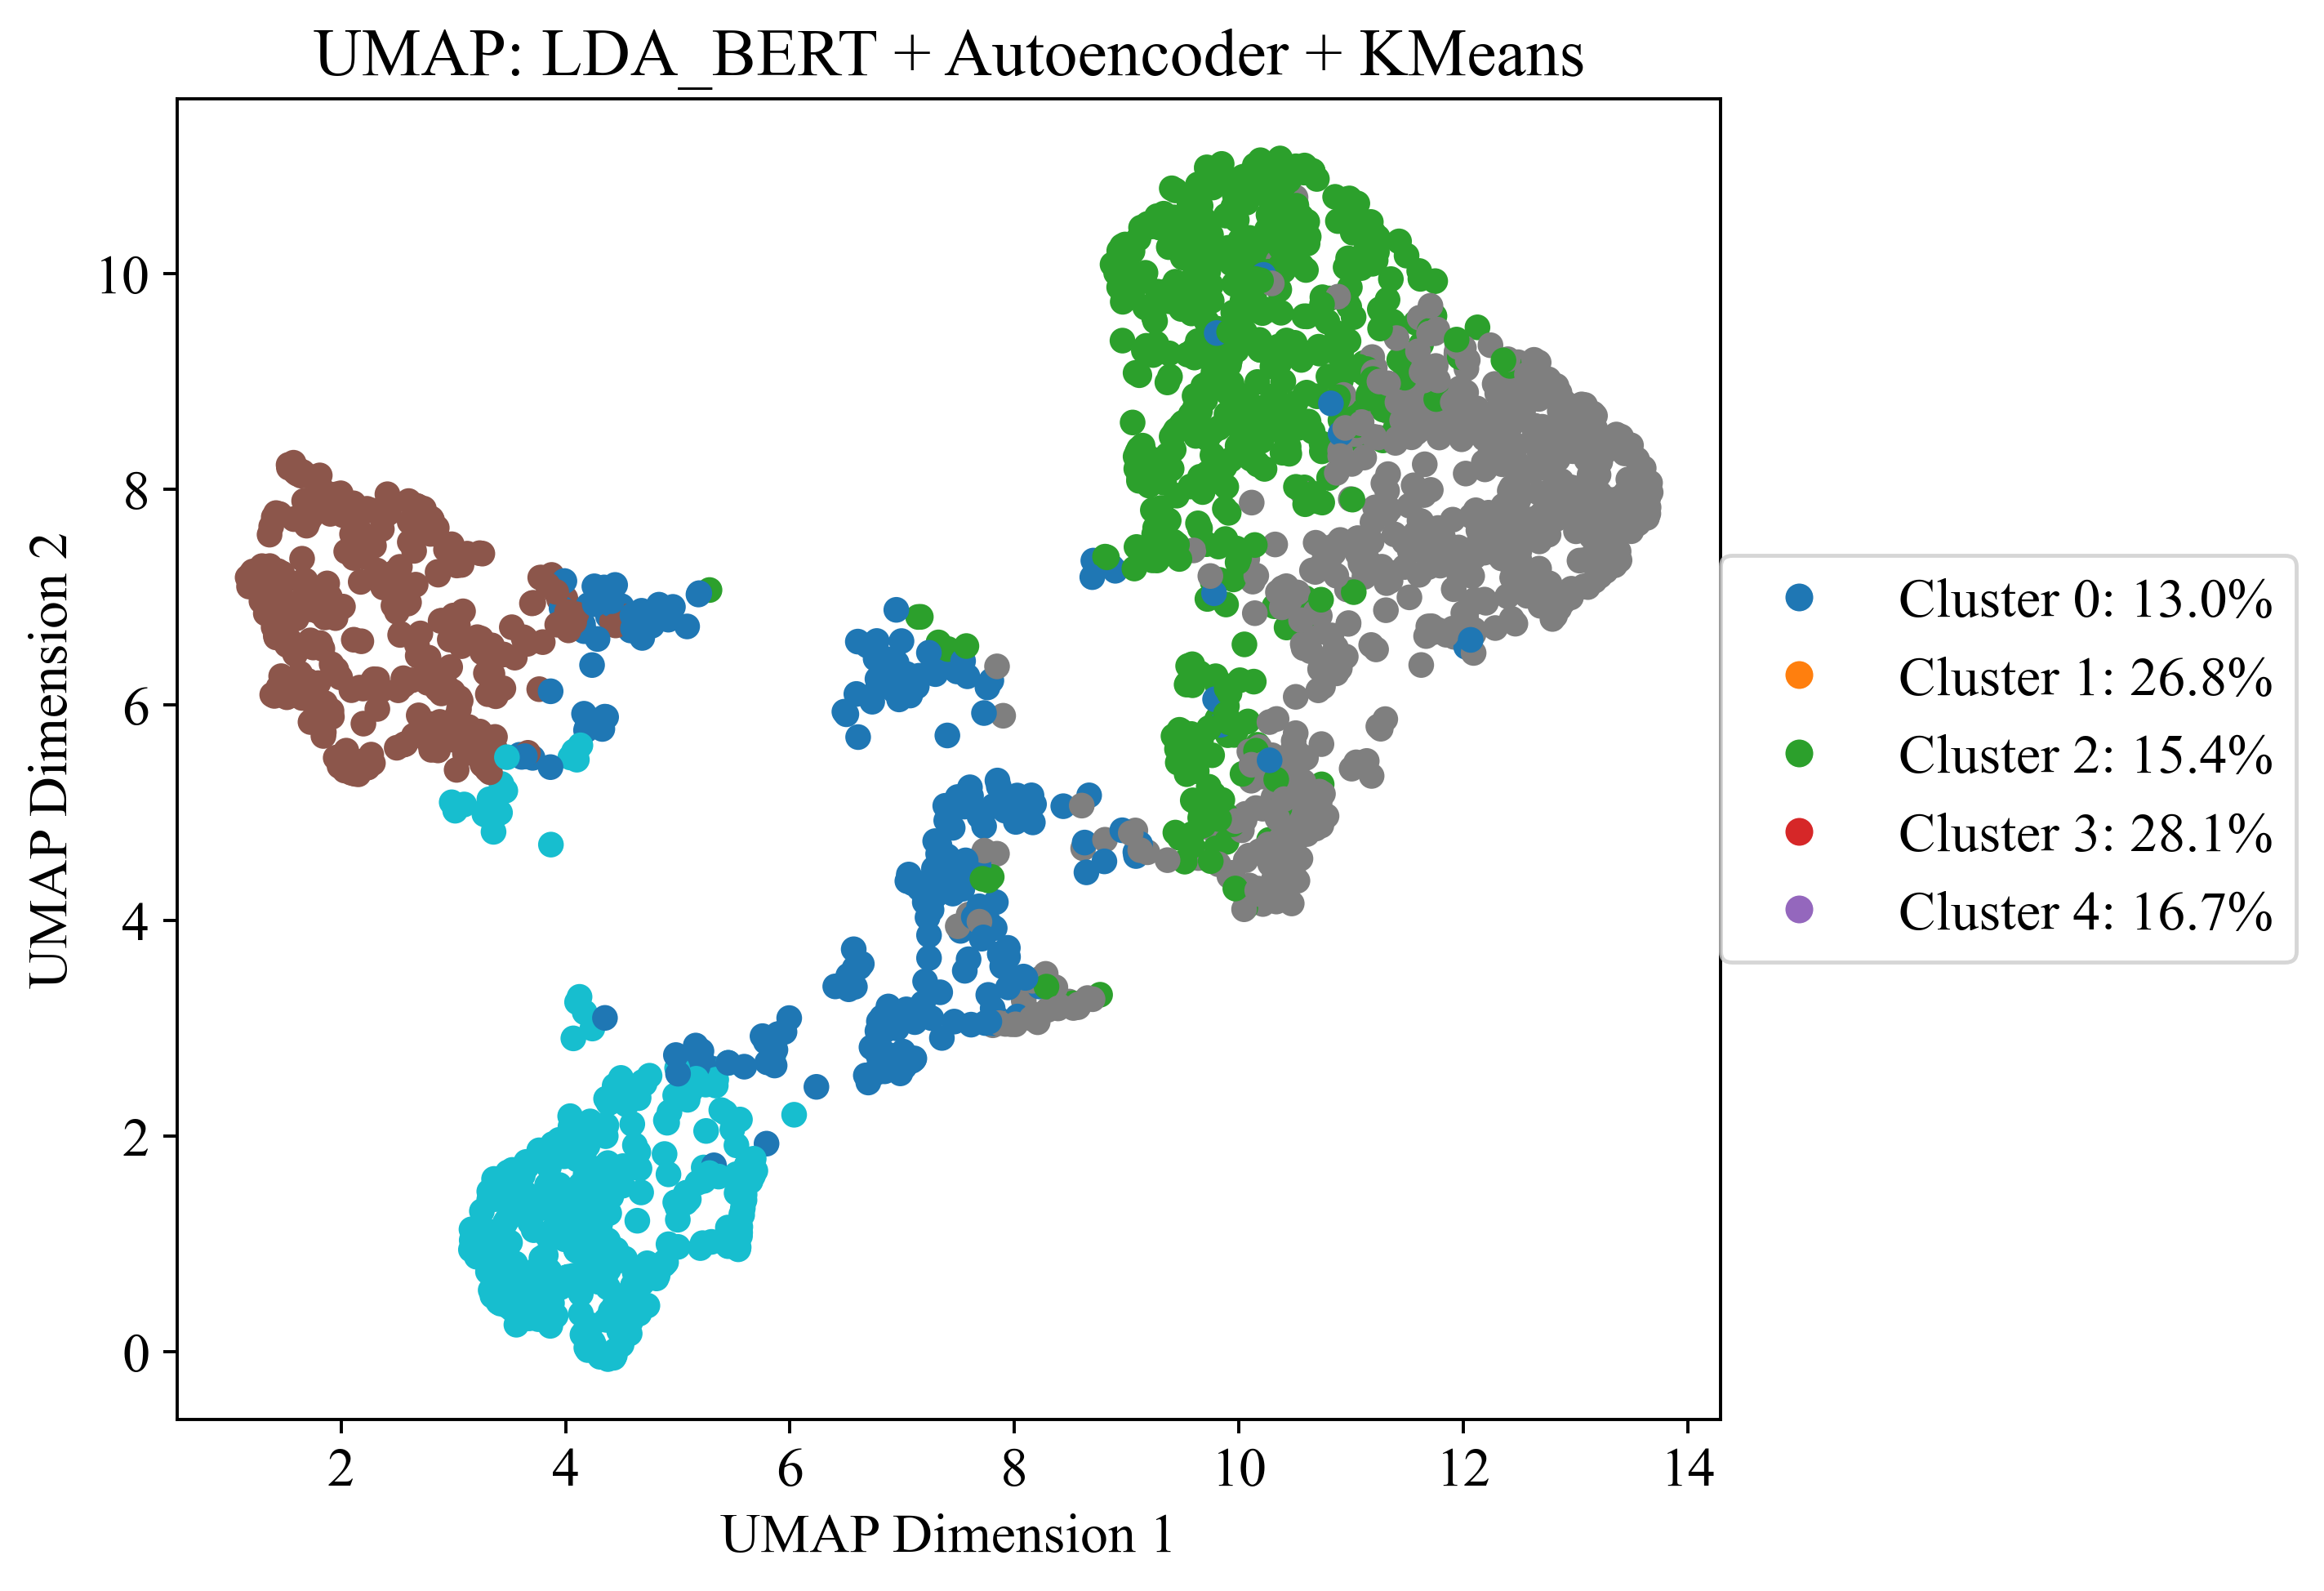

Autoencoder saved as autoencoder.pkl.
LDA_BERT model saved as ldabert_model.pkl.

All models trained and saved successfully.


In [7]:

# ============================== [CELL 7] ==============================
# 7) Train TF-IDF, BERT, LDA_BERT models, evaluate, visualize, save.

print("=== Start of snippet code for training and visualization ===")

plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.size"] = 14

num_clusters = 5  # e.g., BBC has 5 topics
reducer = umap.UMAP(random_state=42)

def plot_proj_with_legend(embedding, labels, title):
    fig, ax = plt.subplots(figsize=(8, 6), dpi=350)
    
    scatter = ax.scatter(embedding[:, 0], embedding[:, 1], c=labels, cmap='tab10', s=30)
    ax.set_title(title)
    ax.set_xlabel('UMAP Dimension 1')
    ax.set_ylabel('UMAP Dimension 2')
    
    unique_labels, counts = np.unique(labels, return_counts=True)
    total_points = len(labels)
    percentages = counts / total_points * 100.0
    
    legend_elements = []
    for i, cluster_id in enumerate(unique_labels):
        color = f"C{cluster_id}"
        label_text = f"Cluster {cluster_id}: {percentages[i]:.1f}%"
        legend_elements.append(
            Line2D([0],[0],
                   marker='o',
                   color='w',
                   label=label_text,
                   markerfacecolor=color,
                   markersize=8)
        )
    legend = ax.legend(
        handles=legend_elements,
        loc="center left",
        bbox_to_anchor=(1, 0.5),
        borderaxespad=0
    )
    fig.subplots_adjust(right=0.8)
    plt.show()

print("Notebook snippet for training TF-IDF, BERT, and LDA_BERT models.")


# ---------------- TF-IDF + KMeans ----------------
print("=== METHOD 1: TF-IDF + KMeans ===")
model_tfidf = Topic_Model(k=num_clusters, method='TFIDF')

# Установка пользовательских названий тем
model_tfidf.topic_labels = {
    0: 'tech',
    1: 'business',
    2: 'sport',
    3: 'entertainment',
    4: 'politics'
}

# Инициализация и обучение TF-IDF векторизатора
tfidf = TfidfVectorizer()
X_tfidf = tfidf.fit_transform(sentences)

# Сохранение векторизатора
with open("tfidf_vectorizer.pkl", "wb") as f:
    pickle.dump(tfidf, f)
    print("TF-IDF vectorizer saved as tfidf_vectorizer.pkl.")

# Привязка векторизатора к модели
model_tfidf.vectorizer = tfidf

# Инициализация и обучение KMeans
model_tfidf.cluster_model = KMeans(n_clusters=num_clusters, random_state=42)
model_tfidf.cluster_model.fit(X_tfidf)

labels_tfidf = model_tfidf.cluster_model.labels_

# Вычисление метрик кластеризации
metrics_tfidf = evaluate_clustering(X_tfidf, labels_tfidf, ground_truth=categories)
print("\n--- TF-IDF + KMeans METRICS ---")
for m, v in metrics_tfidf.items():
    print(f"{m}: {v:.4f}")

# Визуализация с помощью UMAP
embedding_tfidf = reducer.fit_transform(X_tfidf)
plot_proj_with_legend(embedding_tfidf, labels_tfidf, "UMAP: TF-IDF + KMeans")

# Сохранение полной модели TF-IDF
with open("tfidf_model.pkl", "wb") as f:
    pickle.dump(model_tfidf, f)
    print("TF-IDF model saved as tfidf_model.pkl.")

print("==============================================\n")

# ---------------- BERT + KMeans ----------------
print("=== METHOD 2: BERT + KMeans ===")
model_bert = Topic_Model(k=num_clusters, method='BERT')

model_bert.topic_labels = {
    0: 'tech',
    1: 'business',
    2: 'sport',
    3: 'entertainment',
    4: 'politics'
}

# Обучение модели BERT
model_bert.fit(sentences, token_lists)

X_bert = model_bert.vec['BERT']
labels_bert = model_bert.cluster_model.labels_

# Вычисление метрик кластеризации
metrics_bert = evaluate_clustering(X_bert, labels_bert, ground_truth=categories)
print("\n--- BERT + KMeans METRICS ---")
for m, v in metrics_bert.items():
    print(f"{m}: {v:.4f}")

# Визуализация с помощью UMAP
embedding_bert = reducer.fit_transform(X_bert)
plot_proj_with_legend(embedding_bert, labels_bert, "UMAP: BERT + KMeans")

# Сохранение полной модели BERT
with open("bert_model.pkl", "wb") as f:
    pickle.dump(model_bert, f)
    print("BERT model saved as bert_model.pkl.")

print("==============================================\n")

# ---------------- LDA_BERT + Autoencoder + KMeans ----------------
print("=== METHOD 3: LDA_BERT + KMeans ===")
model_ldabert = Topic_Model(k=num_clusters, method='LDA_BERT')

model_ldabert.topic_labels = {
    0: 'tech',
    1: 'business',
    2: 'sport',
    3: 'entertainment',
    4: 'politics'
}

# Обучение модели LDA_BERT
model_ldabert.fit(sentences, token_lists)

X_ldabert = model_ldabert.vec['LDA_BERT']
labels_ldabert = model_ldabert.cluster_model.labels_

# Вычисление метрик кластеризации
metrics_ldabert = evaluate_clustering(X_ldabert, labels_ldabert, ground_truth=categories)
print("\n--- LDA_BERT + KMeans METRICS ---")
for m, v in metrics_ldabert.items():
    print(f"{m}: {v:.4f}")

# Вычисление когерентности LDA (опционально)
if model_ldabert.ldamodel is not None:
    cm = CoherenceModel(
        model=model_ldabert.ldamodel,
        texts=token_lists,
        dictionary=model_ldabert.dictionary,
        corpus=model_ldabert.corpus,
        coherence='c_v'
    )
    coherence_ldabert = cm.get_coherence()
    print(f"Coherence (LDA part, c_v): {coherence_ldabert:.4f}")

# Визуализация с помощью UMAP
embedding_ldabert = reducer.fit_transform(X_ldabert)
plot_proj_with_legend(embedding_ldabert, labels_ldabert, "UMAP: LDA_BERT + Autoencoder + KMeans")

# Сохранение автоэнкодера
if model_ldabert.AE:
    with open("autoencoder.pkl", "wb") as f:
        pickle.dump(model_ldabert.AE, f)
    print("Autoencoder saved as autoencoder.pkl.")

# Сохранение полной модели LDA_BERT
with open("ldabert_model.pkl", "wb") as f:
    pickle.dump(model_ldabert, f)
    print("LDA_BERT model saved as ldabert_model.pkl.")

print("==============================================\n")
print("All models trained and saved successfully.")


In [10]:
# ============================ [ЯЧЕЙКА 9] ============================
print("==== Итоговое сравнение ====")

print("\nTF-IDF + KMeans METRICS:")
for k, v in metrics_tfidf.items():
    print(f"{k}: {v:.4f}")

print("\nBERT + KMeans METRICS:")
for k, v in metrics_bert.items():
    print(f"{k}: {v:.4f}")

print("\nLDA_BERT + KMeans METRICS:")
for k, v in metrics_ldabert.items():
    print(f"{k}: {v:.4f}")
    
if model_ldabert.ldamodel is not None:
    print(f"Coherence (LDA part, c_v): {coherence_ldabert:.4f}")
    
print("\n==== Конец ====")


==== Итоговое сравнение ====

TF-IDF + KMeans METRICS:
silhouette: 0.0029
calinski_harabasz: 14.4955
davies_bouldin: 8.0584
adjusted_rand: 0.4277
homogeneity: 0.5581
completeness: 0.6408
v_measure: 0.5966

BERT + KMeans METRICS:
silhouette: 0.0528
calinski_harabasz: 102.1483
davies_bouldin: 3.5202
adjusted_rand: 0.3837
homogeneity: 0.4128
completeness: 0.4124
v_measure: 0.4126

LDA_BERT + KMeans METRICS:
silhouette: 0.2258
calinski_harabasz: 1488.9133
davies_bouldin: 1.5869
adjusted_rand: 0.4185
homogeneity: 0.4659
completeness: 0.4779
v_measure: 0.4718
Coherence (LDA part, c_v): 0.3413

==== Конец ====


In [11]:
import pickle
import numpy as np

# Assuming that preprocess_sent and preprocess_word functions, as well as the Topic_Model class, are already defined

# Dictionary for interpreting cluster/topic labels
topic_names = {
    0: 'tech', 
    1: 'business', 
    2: 'sport', 
    3: 'entertainment', 
    4: 'politics'
}

# Test texts to classify
test_texts = [
    # Tech
    "The rapid advancement in quantum computing has the potential to revolutionize industries by making data processing significantly faster.",
    "Emerging technologies such as blockchain and IoT are becoming pivotal in shaping the future landscape of digital transactions and smart homes.",
    
    # Business
    "Global markets are increasingly volatile, with trade tensions and geopolitical uncertainties affecting investor sentiment.",
    "Startups are finding it more challenging to secure funding as venture capitalists tighten their criteria in a post-pandemic economy.",
    
    # Sport
    "The sports world is eagerly anticipating the upcoming Olympics, where new records are expected to be set in various disciplines.",
    "Major League Baseball sees a historic season as a young rookie breaks the long-standing home run record.",
    
    # Entertainment
    "The film industry is seeing a shift towards streaming platforms, which are now premiering blockbuster movies directly to consumers at home.",
    "Virtual reality concerts are gaining popularity, offering an immersive experience for fans to see their favorite artists perform live.",
    
    # Politics
    "Election campaigns are increasingly relying on social media to engage with voters, raising concerns about misinformation and data privacy.",
    "International relations are tense as negotiations stall on climate change initiatives, with major countries failing to agree on emissions targets."
]

# Paths to models and files
model_files = {
    'tfidf':   "tfidf_model.pkl",
    'bert':    "bert_model.pkl",
    'ldabert': "ldabert_model.pkl"
}
# Path to the separate TF-IDF vectorizer file
vectorizer_path = "tfidf_vectorizer.pkl"

def predict_with_model(model, test_texts):
    """
    Make predictions for the given texts using the loaded model.
    """
    if model.method in ["TFIDF", "BERT"]:
        cleaned_sentences = [preprocess_sent(txt) or "" for txt in test_texts]

        if model.method == "TFIDF":
            X_new = model.vectorizer.transform(cleaned_sentences)
        elif model.method == "BERT":
            X_new = model.bert_encoder.encode(cleaned_sentences, show_progress_bar=False)
            X_new = np.array(X_new)
        
        cluster_ids = model.cluster_model.predict(X_new)

        for i, cid in enumerate(cluster_ids):
            topic_label = model.topic_labels.get(cid, f"unknown_{cid}")
            print(f"Text #{i+1}: '{test_texts[i][:50]}...' => cluster {cid} => '{topic_label}'")

    elif model.method in ["LDA", "LDA_BERT"]:
        processed_test_texts = [preprocess_word(preprocess_sent(t)) for t in test_texts]
        test_corpus = [model.dictionary.doc2bow(tokens) for tokens in processed_test_texts]
        test_topics = [model.ldamodel.get_document_topics(bow) for bow in test_corpus]

        for i, topics_distribution in enumerate(test_topics):
            print(f"\nText #{i+1}: '{test_texts[i][:70]}...'")
            for topic_id, prob in topics_distribution:
                topic_name = topic_names.get(topic_id, f"unknown_{topic_id}")
                print(f"  Topic '{topic_name}' (id={topic_id}): {prob:.4f}")
            best_topic_id, best_prob = max(topics_distribution, key=lambda x: x[1])
            best_topic_name = topic_names.get(best_topic_id, f"unknown_{best_topic_id}")
            print(f"  => BEST TOPIC: '{best_topic_name}' ({best_prob:.4f})")

print("Loading and evaluating models...")

# === Loading models and making predictions ===
for model_key, file_path in model_files.items():
    print(f"\n=== MODEL: {model_key} ({file_path}) ===")
    try:
        with open(file_path, "rb") as f:
            model = pickle.load(f)

        # If it is a TF-IDF model, load the vectorizer if missing
        if model.method == "TFIDF" and not hasattr(model, 'vectorizer'):
            try:
                with open(vectorizer_path, "rb") as vec_file:
                    model.vectorizer = pickle.load(vec_file)
                    print("TF-IDF vectorizer loaded and assigned to the model.")
            except FileNotFoundError:
                print("TF-IDF vectorizer not found.")

        # Make predictions using the model
        predict_with_model(model, test_texts)

    except FileNotFoundError:
        print(f"File not found: {file_path}")

print("\nAll models have been evaluated on the test texts.")


Loading and evaluating models...

=== MODEL: tfidf (tfidf_model.pkl) ===
Text #1: 'The rapid advancement in quantum computing has the...' => cluster 2 => 'sport'
Text #2: 'Emerging technologies such as blockchain and IoT a...' => cluster 2 => 'sport'
Text #3: 'Global markets are increasingly volatile, with tra...' => cluster 2 => 'sport'
Text #4: 'Startups are finding it more challenging to secure...' => cluster 2 => 'sport'
Text #5: 'The sports world is eagerly anticipating the upcom...' => cluster 2 => 'sport'
Text #6: 'Major League Baseball sees a historic season as a ...' => cluster 2 => 'sport'
Text #7: 'The film industry is seeing a shift towards stream...' => cluster 2 => 'sport'
Text #8: 'Virtual reality concerts are gaining popularity, o...' => cluster 2 => 'sport'
Text #9: 'Election campaigns are increasingly relying on soc...' => cluster 2 => 'sport'
Text #10: 'International relations are tense as negotiations ...' => cluster 2 => 'sport'

=== MODEL: bert (bert_model.pkl) ==